# 2장 - 머신러닝 프로젝트 처음부터 끝까지

### 큰 그림 보기

##### 목표
캘리포니아 인구조사 데이터를 사용해 캘리포니아의 주택 가격 모델을 만드는 것
(해당 모델로 다른 측정 데이터가 주어졌을 때 구역의 중간 주택 가격을 예측해야 함)

##### 문제 정의

만들어야 하는 컴포넌트는 구역의 중간 주택 가격을 예측해야 한다.
예측 결과는 다른 컴포넌트의 입력으로 사용된다.
(이렇게 데이터 처리 컴포넌트들이 연속되어 있는 것을 데이터 파이프라인이라고 한다.)

현재 상황은 사람이 직접 데이터를 수집해 중간 가격을 구하거나 데이터가 부족한 경우 복잡한 규칙을 통해 추정하고 있다.
하지만 오차가 큰 상태이며 머신러닝을 통해 모델을 훈련시켜 사용한다.

각 샘플에 레이블(중간 주택 가격)이 있으므로 **지도 학습** 알고리즘을 사용해야 하며, 값을 예측해야 하고 사용할 피쳐가 여러개(구역의 인구, 중간 소득 등)니까 **다중 회귀(multiple regression)** 문제이다.
각 구역마다 하나의 값을 예측하므로 **단변량 회귀(univariate regression)** 문제이다. (여러개의 값을 예측하면 다변량 회귀(multivariate regression) 문제)
그리고 데이터가 연속적이지 않으며 크기가 작고 빠르게 적응해야 할 필요가 없으므로 **배치 학습** 이 적절하다.

##### 성능 측정 지표 선택

회귀 문제의 전형적인 성능 지표는 **평균 제곱근 오차(Root Mean Square Error)** 이다.

$$RSME(X,h) = \sqrt {\frac {1} {m} \sum_{i=1}^m (h(x^{(i)}) - y^{(i)}) ^ 2}$$

$m$: RMSE를 측정할 데이터셋에 있는 샘플 수
$x^{(i)}$ 는 데이터셋에 있는 i번째 샘플의 전체 특성값의 벡터이고, $y^{i}$ 는 해당 레이블이다.

예를 들어 데이터셋에 있는 첫 번째 구역이 경도 -118.29°, 위도 33.91°에 위치하고, 중간 소득이 $ 38,372이며, 주민이 1,416명, 중간 주택 가격이 $ 156,400라면

$$x^{(i)} = \begin{pmatrix} \\
-118.29 \\
33.91 \\
1,416 \\
38,372 \\
\end{pmatrix}$$
$$y^{(i)} = 156,400$$

$X$ 는 데이터셋에 있는 모든 샘플의 모든 특성값을 포함하는 행렬이다.

$$X = \begin{pmatrix} \\
(x^{(1)})^T \\
(x^{(2)})^T \\
. \\
. \\
. \\
(x^{(1999)})^T \\
(x^{(2000)})^T \\
\end{pmatrix} = \begin{pmatrix} \\
-118.29 & 33.91 & 1,416 & 38,372 \\
. & . & . & . \\
. & . & . & . \\
. & . & . & . \\
\end{pmatrix}$$

$h$ 는 시스템의 예측 함수이며 가설이라고 한다. 시스템이 샘플 특성 벡터 $x^{(i)}$ 를 받으면 예측값 $h(x^{(i)})$ 를 출력한다.

RSME가 일반적으로 회귀 문제에 선호되는 성능 측정 방법이지만 경우에 따라 다른 함수를 사용하기도 한다.
이상치로 보이는 구역이 많다면 **평균 절대 오차(Mean Absolute Error)** 를 사용해 볼 수 있다.

$$MAE(X,h) = \frac {1} {m} \sum_{i=1}^m | h(x^{(i)}) - y^{(i)} |$$

RMSE와 MAE 모두 예측값 벡터와 타깃값의 벡터 사이의 거리를 재는 방법이며, 거리 측정에는 여러가지 방법(또는 norm)이 가능하다.
(norm은 벡터의 크기(magnitude) 또는 길이(length)를 측정하는 방법)

##### 가정 검사

이전 컴포넌트에서 전달받는 데이터의 포맷, 다음 컴포넌트에서 우리 컴포넌트의 결과를 어떻게 사용하는지 등 지금까지 만든 가정들을 다시 한번 체크한다.
다음 컴포넌트에서 가격을 가지고 저가, 보통, 고가등 카테고리로 바꿔 사용한다면 회귀 대신 분류 알고리즘으로 변경해야 한다.

In [97]:
# 파이썬 3.5 이상 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 0.20 이상 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [98]:
# 데이터 다운로드

import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()

In [3]:
# 데이터 로드
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


그림 저장: attribute_histogram_plots


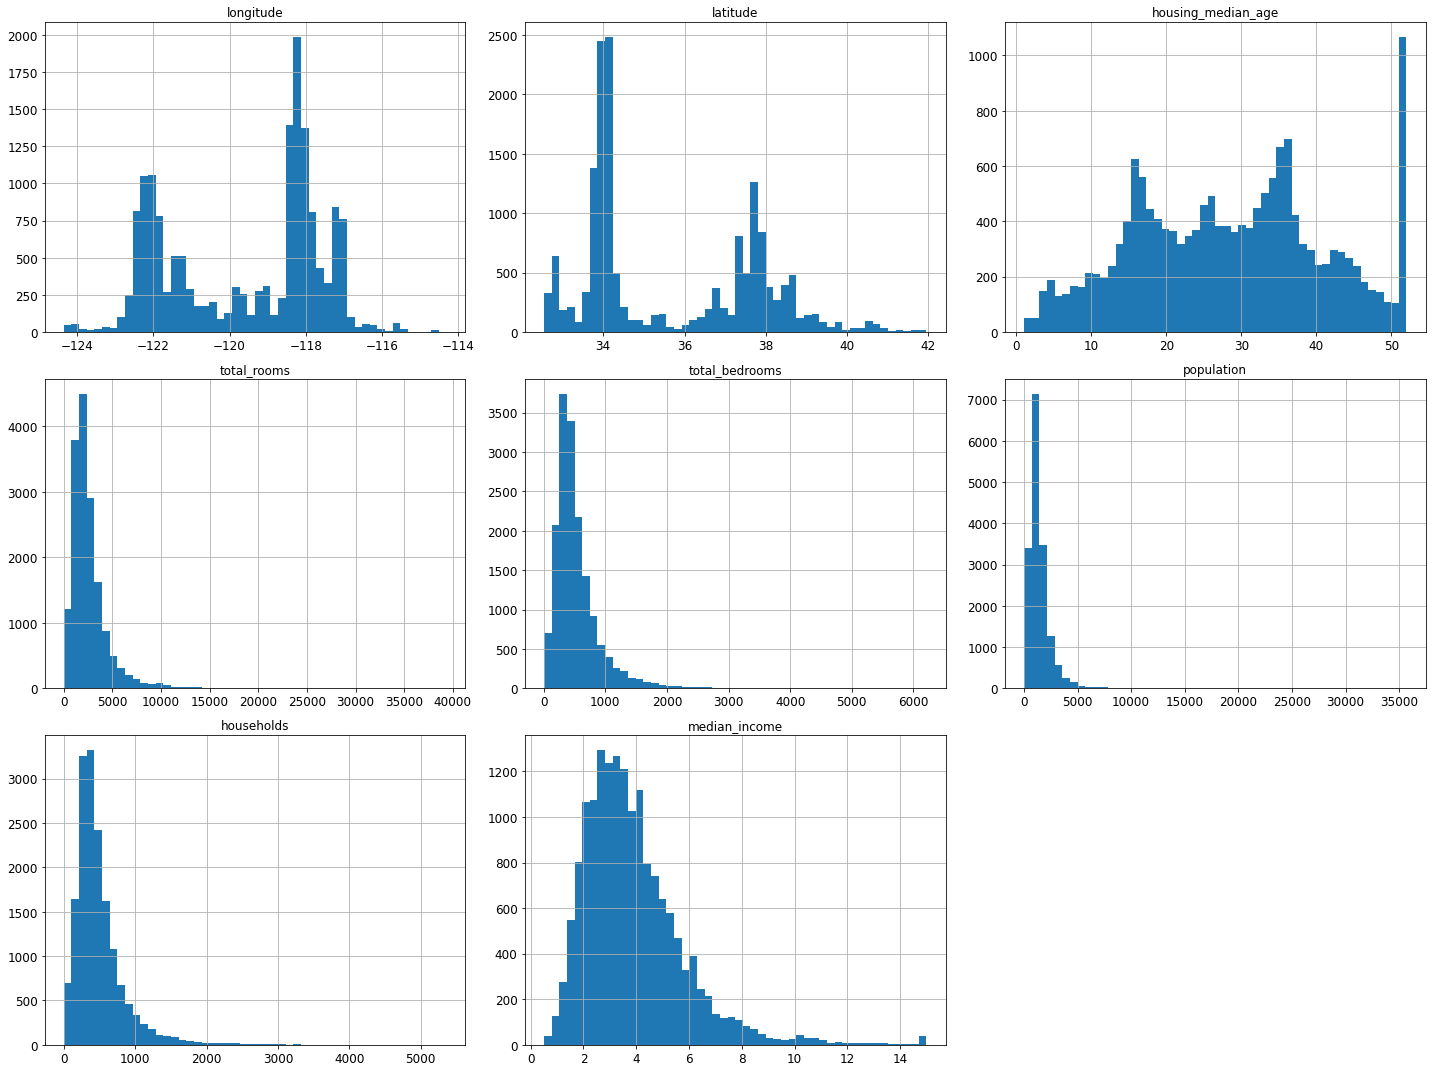

In [99]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

# 특이점
# median_income: 상대값으로 표현됐으며, 대략 0.5에서 15까지 값을 가진다.
# housing median age와 median house value의 최댓값, 최소값이 한정되어 있다. 한계값 밖의 구역에 대한 레이블을 구하거나 제거해 사용해야 한다. (제거하면 최대값 이상되는 값에 대한 예측은 평가 결과가 매우 나쁠 것이다.
# 특성들의 스케일이 많이 다르다.
# 우측 꼬리가 긴 분포가 많다. 이런 형태는 머신러닝 알고리즘에서 패턴 찾기가 어려우므로, 종 모양 분포가 되도록 변경이 필요하다.

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

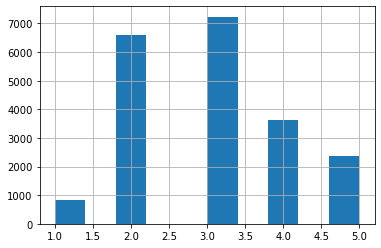

In [21]:
# 테스트 세트 만들기
# 데이터를 오래 들여다 볼 수록 우리의 뇌가 데이터에 과대적합 될 수 있다. (데이터 스누핑 편향)
# 간단하게만 살펴보고 테스트 세트는 분리해 놓자
# 테스트 세트는 보통 전체의 20% 정도이며, 데이터셋이 크다면 20% 보다 적게 사용한다.

# 노트북의 실행 결과가 동일하도록
np.random.seed(42)

# 실행시 마다 테스트 세트가 달라진다. (사용할 수 없음)
# 처음에 train, test set를 분리해 저장해 놓거나, 랜덤 시드를 설정해서 재실행시에도 동일하게 사용할 수 있는 방법이 있다.
# 하지만 데이터셋이 업데이트 되면 동일하게 분리하는걸 보장할 수 없다.
# 예시로 만든 것이며, 실전에서는 사이킷런의 train_test_split()를 사용하자.
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

# 각 샘플의 식별자를 사용해 나눠, 데이터셋이 업데이트 되더라도 테스트 세트에 있던 샘플이 훈련 세트에 섞이지 않게 한다.
from zlib import crc32

# crc32 값에 비트연산을 하는건 파이썬2와 호환성을 유지하기 위해서
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

# 주택 데이터셋에는 식별자 컬럼이 없다.
housing_with_id = housing.reset_index()

# 고유 식별자를 만들 수 있는 안전한 특성인 위도와 경로를 사용해 ID를 만든다.
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]

train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

# 사이킷런에서 제공하는 메소드
from sklearn.model_selection import train_test_split

# random_state는 난수 초깃값
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

# 위에 방식은 랜덤 샘플링 방식으로 데이터셋이 충분히 클 때 사용해야 한다.
# 데이터셋이 충분히 크지 않다면 샘플링 편향이 생길 가능성이 크다.
# 샘플링 데이터가 대표성을 가질 수 있도록 각 동질 그룹(계층)의 비율을 유지해야 한다. 이를 계층적 샘플링(stratified sampling) 이라고 한다.
# 계층별로 데이터셋에 충분한 샘플 수가 있어야 한다. (너무 많은 계층으로 나누면 안되고 각 계층이 충분히 커야 한다.)

# 전문가가 중간 소득이 중간 주택 가격을 예측하는데 매우 중요하다고 함. 따라서 중간 소득으로 카테고리 특성을 만든다.
# 5개 카테고리를 가지는 소득 카테고리 특성 추가
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0, 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

housing["income_cat"].hist()

# "income_cat"으로 계층 샘플링
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

strat_test_set["income_cat"].value_counts() / len(strat_test_set)

계층 샘플링을 사용해 만든 테스트 세트는 전체 데이터셋에 있는 소득 카테고리 비율과 거의 같다.

<img alt="image" src="https://user-images.githubusercontent.com/12126093/200153438-aadd613e-41be-4173-827f-033a7086867b.png" width="600"/>

In [ ]:
# income_cat 사용 후 삭제
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

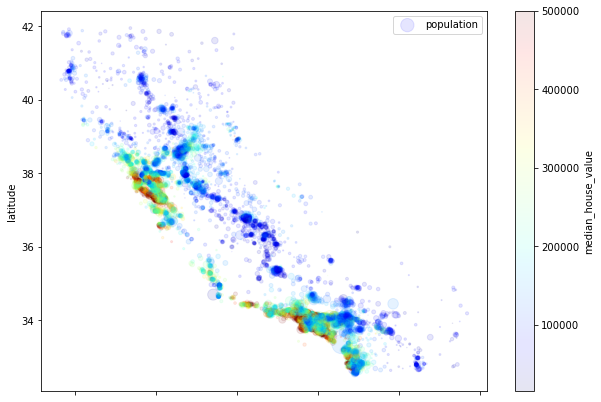

In [28]:
# 데이터 이해를 위한 탐색과 시각화
# 훈련 세트만 탐색하며, 훈련 세트가 너무 커서 빠르게 사용이 어렵다면 샘플링해서 사용하면 좋다.

# 훈련 세트를 손상시키지 않기 위해 복사해 사용
housing = strat_train_set.copy()

# 지리적 데이터 시각화
# alpha 값을 주면 밀집된 포인트를 볼 수 있다.
# 원의 반지름(s)은 구역의 인구, 색상(c)는 가격이며 미리 정의된 컬러맵(cmap) jet을 사용
# 주택 가격은 지역과 인구 밀도에 영향을 크게 받는 걸 알 수 있음
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)

plt.legend()

In [30]:
# 상관 관계 조사

# 데이터셋이 크지 않아서 모든 특성 간의 표준 상관계수(standard correlation coefficient)를 계산
corr_matrix = housing.corr()

# 중간 주택 가격과 다른 특성 사이의 상관관계 (-1 ~ 1)
# 중간 주택 가격은 중간 소득과 양의 상관관계를 가진다.
# 위도와는 약한 음의 상관관계가 보인다.
# 0에 가까우면 선형적인 상관관계가 없음을 의미한다.
# 상관계수는 선형적인 상관관계만 측정할 수 있다. (증가/감소만)
# x가 0에 가까워지면 y가 증가한다 등은 알 수 없다.
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

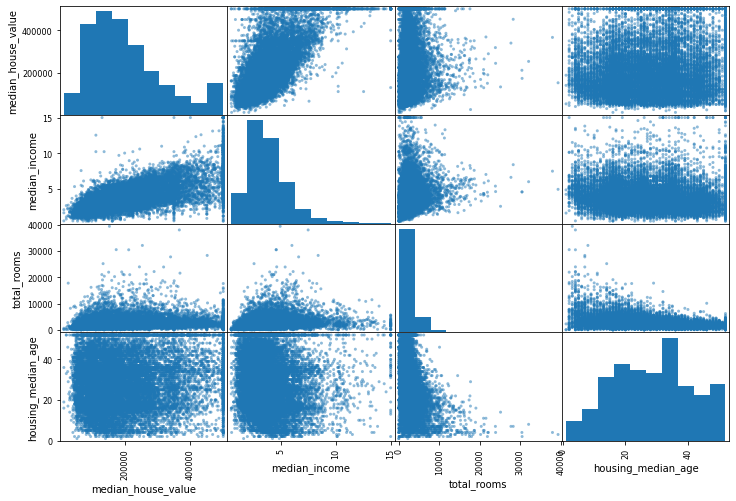

In [31]:
# 특성이 11개여서 전체 (11*11)개의 상관관계를 모두 보기는 어려워 상관이 높아보이는 몇 개만 본다.

from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]

# 자신에 대한 상관관계는 직선이 되므로 판다스에서는 해당 특성의 히스토그램을 그린다.
scatter_matrix(housing[attributes], figsize=(12,8))

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

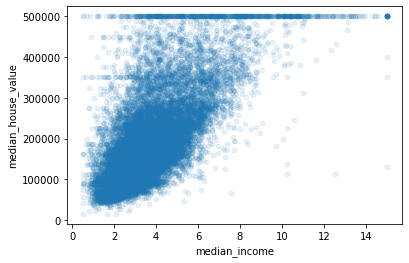

In [33]:
# 중간 주택 가격과 중간 소득의 상관관계가 높아보여 산점도를 확대해 보자

# 그래프에서 둘의 상관관계가 매우 강함을 알 수 있다. 위로 향하며 포인트가 너무 널리 퍼져 있지 않음
# 가격 제한선에서 수평선이 보이는데 알고리즘이 이상한 형태를 학습하지 않도록 제거가 필요하다.
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

In [34]:
# 특성 조합으로 실험

# 마지막으로 여러 특성의 조합을 시도해 보자
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

# 침대/방 비율이 낮은 집은 더 비싼 경향이 있다.
# 조합한 특성들이 더 강한 상관관계를 보여주고 있다.
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

In [158]:
# 데이터 준비

# 데이터는 함수로 로드하는걸 자동화 시켜놔야 한다.
# 1. 사용하는 데이터셋이 많기 때문에 한번 만들어 놓으면 다음에 사용하기 쉽다.
# 2. 자신의 템플릿을 만들어 두고 점차 발전시켜 나갈 수 있다.
# 3. 실제 시스템에 적용이 쉽고 빠르다.

# drop은 복사본을 만들며, 원본에 영향을 주지 않는다.
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [38]:
# 일부 값이 없는 total_bedrooms 특성을 고쳐보자

# total_bedrooms 값이 없는 행을 제거
housing.dropna(subset=["total_bedrooms"])

# total_bedrooms 컬럼 전체 제거
housing.drop("total_bedrooms", axis=1)

# total_bedrooms 값이 없는 경우 해당 특성의 중앙값으로 채움
# 해당 값은 저장해 두고 실제 환경에서 해당 특성이 없을 때 채워 사용해야 한다.
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)

In [41]:
# 사이킷런 SimpleImputer를 사용하면 누락된 값을 쉽게 채울 수 있다.

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

# 중간값은 수치형만 계산될 수 있으므로 문자열 타입 컬럼은 제거
housing_num = housing.drop("ocean_proximity", axis=1)

# 훈련 데이터에 적용
imputer.fit(housing_num)

# 각 특성의 중간값 확인
print(imputer.statistics_)

# 훈련 세트에서 누락된 값을 학습한 중간값으로 바꿈 (넘파이 배열)
X = imputer.transform(housing_num)

# 넘파이 배열 -> 판다스 데이터프레임
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

[-118.51      34.26      29.      2119.       433.      1164.
  408.         3.54155]


In [48]:
# 텍스트와 범주형 특성 다루기

# 대부분의 머신러닝 알고리즘은 숫자를 다루므로 ocean_proximity의 카테고리형 특성을 숫자로 변환
from sklearn.preprocessing import OrdinalEncoder

housing_cat = housing[["ocean_proximity"]]
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

# 숫자가 가까우면 카테고리의 특성도 비슷하다고 생각할 수 있는 단점이 있다.
# ocean_proximity는 값이 가깝다고 해서 성질이 비슷하지 않다. (데이터가 선형이여서 머신러닝 알고리즘이 관계가 있다고 학습한다.)
# 랭크 같은 값은 ordinal encoder가 맞다
print("Ordinal Encoder")
print(housing_cat_encoded[:10])
print(ordinal_encoder.categories_)

# One-hot encoder
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
# 결과는 SciPy의 희소 행렬(sparse matrix)
# 희소 행렬을 사용해 값이 1인 위치만 저장해 메모리 사용량을 줄인다.
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

print("One-Hot Encoder")
# 희소행렬 -> 넘파이 배열
print(housing_cat_1hot.toarray())

Ordinal Encoder
[[1.]
 [4.]
 [1.]
 [4.]
 [0.]
 [3.]
 [0.]
 [0.]
 [0.]
 [0.]]
[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]
One-Hot Encoder
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [49]:
# 커스텀 변환기 만들기
# 내가 원하는 대로 변환하는 메소드가 없을 경우, 직접 만들어 사용해야 한다.
# scikit-learn은 덕 타이핑을 지원해서, 프로퍼티와 메소드가 같으면 같은 타입으로 봐서 사이킷런 기능과 연동이 된다.
# 따라서, fit(), transform(), fit_transform() 메소드를 구현하면 된다.
# fit_transform() 메소드는 TransformerMixin을 상속하면 자동으로 생성된다. fit_transform() 메소드는 단순히 fit()과 transform()을 method chaining한 것이다. (파이썬에서 이름에 Mixin이 있으면, 객체의 기능을 확장하려는 목적으로 나타내는 클래스를 의미한다.)
# BaseEstimator를 상속하면 하이퍼파라미터 튜닝에 필요한 get_params()와 set_params() 메소드를 추가로 얻게 된다.

from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    # *args, **kargs를 사용하지 않아야 get_params()와 set_params() 메소드를 얻을 수 있다.
    # CombinedAttributesAdder 변환기는 하나의 하이퍼파라미터(add_bedrooms_per_room)를 가진다.
    # 이렇게 하이터파라미터 추가 기능을 만들어 놓으면, 해당 값을 변경해 가며 하이퍼파라미터 여부에 대한 성능값을 쉽게 확인할 수 있다.
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [53]:
# 특성 스케일링 (feature scaling)
# 머신러닝 알고리즘들은 숫자 특성들의 스케일이 많이 다르면 잘 작동하지 않기 떄문에, 특성 값의 스케일을 맞춰줘야 한다. (타깃값은 제외)
# min-max 스케일링과 표준화(standardization)이 널리 사용된다.
# min-max 스케일링은 MinMaxScaler 변환기를 사용할 수 있으며, feature_range 매개변수로 범위를 0~1 밖으로 변경할 수 있다.
# 표준화는 범위의 상한과 하한기 없다. 일부 입력값의 범위를 0~1로 생각하는 신경망 같은 알고리즘에서는 문제가 될 수 있다. 하지만 이상치에 영향을 덜 받는다. (min-max 스케일링은 이상치도 범위안에 넣으면서 다른 값들이 영향을 받는다.)
# 스케일링은 훈련데이터 에서만 fit 해야한다. 이 후 전체 데이터세트에서 transform 해야 한다.
# 표준화는 StandardScaler 변환기를 사용할 수 있다.

In [54]:
# 변환 파이프라인
# 파이프라인은 연속된 변환을 순서대로 처리할 수 있게 도와준다.

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [66]:
# ColumnTransformer를 사용해 컬럼마다 다르게 변환을 할 수 있다.

from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

In [71]:
# 모델 선택과 훈련

# 선형 회귀 모델 사용
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

# 일부 샘플로 평가
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

# 예측 오차가 커서 성능이 매우 나쁘다
# 모델이 훈련 데이터에 과소적합된 사례로, 더 강력한 모델로 변경하거나 훈련 알고리즘에 더 좋은 특성을 주입해야 한다. (모델의 규제를 감소시키는 방법도 있지만 이 모델은 규제를 사용하지 않아서 제외)
print("예측: ", lin_reg.predict(some_data_prepared))
print("레이블: ", list(some_labels))

from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
line_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(line_mse)
print("RMSE: ", lin_rmse)

예측:  [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
레이블:  [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]
RMSE:  68627.87390018745


In [73]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)

# 오차가 0인건 모델이 데이터에 심하게 과대적합 되었다는걸 의미한다.
print(tree_rmse)

0.0


In [76]:
# 교차 검증을 사용한 평가

# K-fold cross-validation
from sklearn.model_selection import cross_val_score

# scoring 매개변수는 비용 함수가 아닌 효용 함수를 기대한다. 따라서 MSE의 음수값을 사용한다.
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("점수: ", scores)
    print("평균: ", scores.mean())
    print("표준편차: ", scores.std())

# 점수가 선형 회귀 모델보다 나쁘다!!
# 검증세트를 하나만 사용했다면 몰랐을텐데, 여러번 사용해 성능이 좋지 않다는걸 찾아낼 수 있었다.
# 교차검증은 모델을 여러번 훈련 시켜야 해서 비용이 비싸다. 매번 교차 검증을 사용할 수 있는게 아니다.
display_scores(tree_rmse_scores)

점수:  [72972.26198308 70828.71601368 69051.2369369  72230.79082517
 70395.15988067 75133.78235151 69939.27773347 72518.2405871
 68923.57489055 71424.78139959]
평균:  71341.78226017121
표준편차:  1828.652036634571


In [77]:
# 선형 회귀 모델의 점수도 계산해 보자

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

점수:  [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
평균:  69104.07998247063
표준편차:  2880.3282098180657


In [79]:
# 랜덤 포레스트를 적용해 보자!!

from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

# 랜덤 포레스트가 결과 값이 선형 회귀나 결정 트리보다 좋다.
# 훈련 세트에 대한 점수가 검증 세트에 대한 점수보다 훨씬 낮아서, 모델이 훈련 세트에 과대적합되어 있는걸 알 수 있다.
# 모델을 간단하게 하거나 규제를 하거나 더 많은 훈련 데이터를 모아야 한다.
# 랜덤 포레스트를 파기 전에 다양한 머신러닝 알고리즘을 시도해 2~5개 정도 모델을 선정해야 한다.
display_scores(forest_rmse_scores)

점수:  [51625.9321141  48745.83366614 46964.19413371 51959.98328333
 46995.43599761 51817.03465618 52291.14584539 49744.90591131
 48640.83743568 53634.36500945]
평균:  50241.966805292104
표준편차:  2222.344140226916


In [80]:
# 모델 저장
import joblib

# 저장
# joblib.dump(my_model, "my_model.pkl")

# 로드
# my_model_loaded = joblib.load("my_model.pkl")

In [81]:
# 모델 세부 튜닝
# 가능성 있는 모델을 추렸다고 가정하고, 모델들에 대한 세부 튜닝을 해보자

# 그리드 탐색
# 지정한 하이퍼파라미터 조합에 대해 교차 검증을 평가한다.
# RandomForestRegressor에 대한 최적의 하이퍼파라미터 조합을 탐색한다.
# 그리드 탐색은 비교적 적은 수의 조합을 탐구할 때 좋다. 탐색 공간이 커지면 RandomizedSearchCV를 사용하는게 낫다.
# RandomizedSearchCV는 전체를 탐색하지 않고 각 반복마다 임의의 수를 대입해 지정한 횟수만큼 평가한다.
from sklearn.model_selection import GridSearchCV

# (3*4) + (2*3) = 18개의 조합을 탑색하고 다섯번 모델을 훈련시킨다.
# 총 훈련 횟수는 90(5 * 18)번이다.
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring="neg_mean_squared_error",
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

print(grid_search.best_params_)

{'max_features': 8, 'n_estimators': 30}


In [84]:
# 평가 점수 확인

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

# 하이퍼파라미터 'max_features': 8, 'n_estimators': 30 일 때, 점수가 가장 좋다.

64300.35849752295 {'max_features': 2, 'n_estimators': 3}
55451.76407717375 {'max_features': 2, 'n_estimators': 10}
52564.670923453414 {'max_features': 2, 'n_estimators': 30}
60261.794567604215 {'max_features': 4, 'n_estimators': 3}
52701.023178699965 {'max_features': 4, 'n_estimators': 10}
50570.51474787516 {'max_features': 4, 'n_estimators': 30}
58312.705518776 {'max_features': 6, 'n_estimators': 3}
52143.594294584946 {'max_features': 6, 'n_estimators': 10}
50266.45444261782 {'max_features': 6, 'n_estimators': 30}
58691.032866870744 {'max_features': 8, 'n_estimators': 3}
52160.341299293505 {'max_features': 8, 'n_estimators': 10}
50211.86927739008 {'max_features': 8, 'n_estimators': 30}
62949.3718216679 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54456.50058167989 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59386.502445455364 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52078.71212823939 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [86]:
# 선택한 최적의 모델 분석하기

# 각 특성의 상대적 중요도 확인
feature_importances = grid_search.best_estimator_.feature_importances_
print(feature_importances)

# 중요도에 대응하는 특성이름 확인하기
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

# ocean_proximity 카테고리중 INLAND만 유용하므로 나머지 카테고리는 제외할 수 있다.
sorted(zip(feature_importances, attributes), reverse=True)

[7.09689312e-02 6.74238024e-02 4.23296947e-02 1.46875409e-02
 1.43888034e-02 1.48460844e-02 1.38429063e-02 3.37822243e-01
 5.90789135e-02 1.12231836e-01 7.49367383e-02 4.85623494e-03
 1.66587226e-01 1.08654800e-05 2.95807758e-03 3.03010066e-03]


[(0.33782224342014283, 'median_income'),
 (0.16658722646790675, 'INLAND'),
 (0.1122318364165228, 'pop_per_hhold'),
 (0.07493673827171592, 'bedrooms_per_room'),
 (0.07096893119505245, 'longitude'),
 (0.06742380241497026, 'latitude'),
 (0.059078913482299336, 'rooms_per_hhold'),
 (0.04232969470991245, 'housing_median_age'),
 (0.01484608435880556, 'population'),
 (0.014687540873159686, 'total_rooms'),
 (0.01438880341623976, 'total_bedrooms'),
 (0.013842906314361553, 'households'),
 (0.004856234937261372, '<1H OCEAN'),
 (0.0030301006598621063, 'NEAR OCEAN'),
 (0.0029580775817407245, 'NEAR BAY'),
 (1.0865480046520662e-05, 'ISLAND')]

In [87]:
# 테스트 세트로 최종 모델 평가하기

final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

# 일반화 오차의 신뢰도 계산
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
print(np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors))))

[45670.62199475 49558.4759985 ]


In [88]:
# 만든 모델을 배포하자
# 배포 후 실제 데이터에 대한 성능을 모니터링 해야 한다.
# 추천 상품에 대한 판매량등으로 성능을 예측할 수 있지만 사람이 직접 성능을 판단해야 하는 경우도 있다.
# 정기적으로 새로운 데이터를 수집해 훈련시키거나, 주기적으로 모델을 훈련하고 하이퍼파라미터를 자동으로 튜닝하는 스크립트를 작성할 수 있다.
# 테스트 세트 평가값 비교 후 배포하는 파이프라인을 구성한다.
# 모델은 버전 관리를 통해 롤백이 가능하도록 관리해야 한다.

# 연습문제

In [102]:
# 1. 서포트 벡터 머신 회귀(sklearn.svm.SVR)을 kernel="linear"(하이퍼파라미터 C를 바꿔가며)나 kernel="rbf"(하이퍼파라미터 C와 gamma를 바꿔가며) 등의 다양한 하이퍼파라미터 설정으로 시도해보세요. 지금은 이 하이퍼파라미터가 무엇을 의미하는지 너무 신경쓰지 마세요. 최상의 SVR 모델은 무엇인가요?

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

param_grid = [
    {"kernel": ["linear"], "C": [10., 100., 1000., 10000.]},
    {"kernel":["rbf"], "C": [1.0, 10., 100., 1000.], "gamma": [0.01, 0.1, 1.0, 3.0]}
]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring="neg_mean_squared_error", verbose=2)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ..............................C=10.0, kernel=linear; total time=   8.9s
[CV] END ..............................C=10.0, kernel=linear; total time=   8.9s
[CV] END ..............................C=10.0, kernel=linear; total time=   8.8s
[CV] END ..............................C=10.0, kernel=linear; total time=   8.7s
[CV] END ..............................C=10.0, kernel=linear; total time=   8.7s
[CV] END .............................C=100.0, kernel=linear; total time=   8.6s
[CV] END .............................C=100.0, kernel=linear; total time=   8.5s
[CV] END .............................C=100.0, kernel=linear; total time=   8.7s
[CV] END .............................C=100.0, kernel=linear; total time=   8.8s
[CV] END .............................C=100.0, kernel=linear; total time=   8.9s
[CV] END ............................C=1000.0, kernel=linear; total time=   8.8s
[CV] END ............................C=1000.0, 

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [10.0, 100.0, 1000.0, 10000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 10.0, 100.0, 1000.0],
                          'gamma': [0.01, 0.1, 1.0, 3.0], 'kernel': ['rbf']}],
             scoring='neg_mean_squared_error', verbose=2)

In [103]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
print(rmse)

70292.42763594876


In [105]:
grid_search.best_params_

# 선형커널이 RBF 커널보다 성능이 좋은 것으로 보인다.
# C 값은 최대값인 10,000이 선택되었다. 10,000 이상의 C 값들을 해서 그리드서치를 다시 실행해 보면 더 좋은 성능의 C 값을 찾을 수 있을 것이다.

{'C': 10000.0, 'kernel': 'linear'}

In [106]:
# 2. GridSearchCV를 RandomizedSearchCV로 바꿔보세요.

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# kernel이 linear일 때는 gamma가 무시된다.
param_distribs = {
    "kernel": ["linear", "rbf"],
    "C": reciprocal(20, 200000),
    "gamma": expon(scale=1.0),
}

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs, n_iter=50, cv=5, scoring="neg_mean_squared_error", verbose=2, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   8.9s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   8.6s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   8.8s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   8.8s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   8.8s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  16.0s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  16.6s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  16.7s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  16.4s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  16.2s
[CV] END C=84.14107900575871, gamma=0.059838768608680676, 

RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=50,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fdce85dc610>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fdd03bd29d0>,
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [107]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
print(rmse)

54751.69009256623


In [108]:
rnd_search.best_params_

# 그리드 서치와 달리 RBF 커널에 대한 최적의 하이퍼파라미터 조합을 찾았다.
# 보통 같은 시간이라면 랜덤서치가 그리드서치보다 더 좋은 하이퍼파라미터를 찾는다.

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

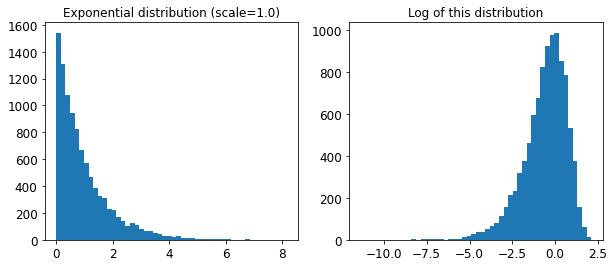

In [121]:
# scale=1.0인 지수 분포를 살펴보자
# 일부 샘플은 1.0보다 아주 크거나 작다.
# 로그 분포는 대부분 값이 exp(-2)와 exp(2), 즉 0.1과 7.4사이에 집중되어 있다.
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

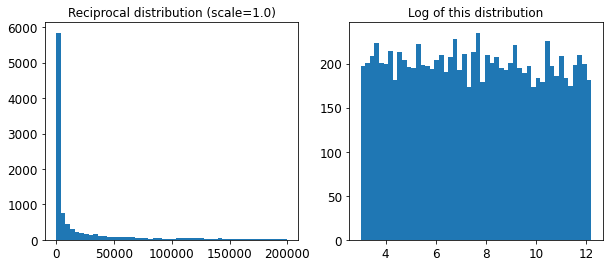

In [122]:
# C에 사용한 분포는 주어진 범위안에서 균등 분포로 샘플링된다.
# reciprocal는 하이퍼파라미터의 스케일에 대해 전혀 감을 잡을 수 없을 때 사용한다.

reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

In [147]:
# 3. 가장 중요한 특성을 선택하는 변환기를 준비 파이프라인에 추가해보세요.

from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k

    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self

    def transform(self, X):
        return X[:, self.feature_indices_]

In [148]:
k = 5
top_k_feature_indices = indices_of_top_k(feature_importances, k)
print(top_k_feature_indices)

print(np.array(attributes)[top_k_feature_indices])

[ 0  7  9 10 12]
['longitude' 'median_income' 'pop_per_hhold' 'bedrooms_per_room' 'INLAND']


In [155]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.33782224342014283, 'median_income'),
 (0.16658722646790675, 'INLAND'),
 (0.1122318364165228, 'pop_per_hhold'),
 (0.07493673827171592, 'bedrooms_per_room'),
 (0.07096893119505245, 'longitude')]

In [156]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [159]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

In [163]:
print(housing_prepared_top_k_features[0:3])
print(housing_prepared[0:3, top_k_feature_indices])

[[-0.94135046 -0.8936472   0.00622264 -0.12112176  1.        ]
 [ 1.17178212  1.292168   -0.04081077 -0.81086696  0.        ]
 [ 0.26758118 -0.52543365 -0.07537122 -0.33827252  1.        ]]
[[-0.94135046 -0.8936472   0.00622264 -0.12112176  1.        ]
 [ 1.17178212  1.292168   -0.04081077 -0.81086696  0.        ]
 [ 0.26758118 -0.52543365 -0.07537122 -0.33827252  1.        ]]


In [165]:
# 4. 전체 데이터 준비 과정과 최종 예측을 하나의 파이프라인으로 만들어보세요.

prepare_select_and_predict_pipeline = Pipeline([
    ("preparation", full_pipeline),
    ("feature_selection", TopFeatureSelector(feature_importances, k)),
    ("svm_reg", SVR(**rnd_search.best_params_))
])

In [166]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                    

In [167]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions: ", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels: ", list(some_labels))

Predictions:  [ 82915.77062052 288057.72329295  95680.82648363 149790.34263836]
Labels:  [72100.0, 279600.0, 82700.0, 112500.0]


In [169]:
# 5. GridSearchCV를 사용해 준비 단계의 옵션을 자동으로 탐색해 보세요.
# OneHotEncoder는 데이터를 변환할 때 훈련 데이터에 없는 범주의 값이 나오면 에러를 낸다. 그래서 에러를 피하기 위해 handle_unknown 파라피터의 값을 ignore로 변경한다.

full_pipeline.named_transformers_["cat"].handle_unknown = 'ignore'

param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/metaestimators.py", line 113, i

[CV] END feature_selection__k=1, preparation__num__imputer__strategy=mean; total time=  10.1s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=mean; total time=  13.6s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=mean; total time=  13.5s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=mean; total time=  13.8s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=mean; total time=  13.6s


/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/metaestimators.py", line 113, i

[CV] END feature_selection__k=1, preparation__num__imputer__strategy=median; total time=   9.9s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=median; total time=  13.5s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=median; total time=  14.0s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=median; total time=  13.7s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=median; total time=  13.6s


/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/metaestimators.py", line 113, i

[CV] END feature_selection__k=1, preparation__num__imputer__strategy=most_frequent; total time=   9.8s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=most_frequent; total time=  13.4s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=most_frequent; total time=  13.5s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=most_frequent; total time=  13.5s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=most_frequent; total time=  13.5s


/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/metaestimators.py", line 113, i

[CV] END feature_selection__k=2, preparation__num__imputer__strategy=mean; total time=  10.2s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=mean; total time=  14.1s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=mean; total time=  14.2s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=mean; total time=  14.3s


KeyboardInterrupt: 

In [ ]:
grid_search_prep.best_params_